# Tarea 1: Análisis de Imagenes con Deep Learning
## Filtro Laplaciano
### Gustavo Hernández Angeles


### Preparacion

In [32]:
!pip -q install cupy-cuda12x

In [33]:
import cupy as cp
from cupy.cuda import Event
import cupy.cuda
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time


#### Función Kernel para aplicar filtros mediante convolución.

In [34]:
def apply_kernel(img_path, kernel_np):
    """
    Args:
        img_path (str): La ruta al archivo de la imagen.
        kernel_np (np.ndarray): El kernel a aplicar como un array de NumPy.

    Returns:
        np.ndarray: La imagen filtrada como un array de NumPy (aún como float32, sin normalizar).
    """
    # Cargar la imagen
    img = Image.open(img_path).convert('L') # Convertir a escala de grises
    img_array = np.array(img)

    # Mover los datos de la imagen a la GPU
    img_gpu = cp.asarray(img_array).astype(cp.float32)

    # Mover el kernel a la GPU
    kernel_gpu = cp.asarray(kernel_np).astype(cp.float32)

    # Definir el kernel CUDA para la convolución
    convolution_kernel_raw = cp.RawKernel(r"""
    extern "C" __global__
    void convolution_filter(const float* input, float* output, const float* kernel, int width, int height, int kernel_size) {
        int x = blockDim.x * blockIdx.x + threadIdx.x;
        int y = blockDim.y * blockIdx.y + threadIdx.y;

        if (x < width && y < height) {
            float sum = 0.0f;
            int kernel_half = kernel_size / 2;

            for (int ky = 0; ky < kernel_size; ++ky) {
                for (int kx = 0; kx < kernel_size; ++kx) {
                    int img_x = x + kx - kernel_half;
                    int img_y = y + ky - kernel_half;

                    // Manejo de bordes: ignorar píxeles fuera de los límites (estrategia "caja negra")
                    if (img_x >= 0 && img_x < width && img_y >= 0 && img_y < height) {
                        sum += input[img_y * width + img_x] * kernel[ky * kernel_size + kx];
                    }
                }
            }
            output[y * width + x] = sum;
        }
    }
    """, 'convolution_filter')

    # Determinar las dimensiones de la grilla y el bloque
    height, width = img_gpu.shape
    kernel_size = kernel_gpu.shape[0]
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Asignar memoria para la imagen de salida en la GPU
    img_filtered_gpu = cp.empty_like(img_gpu)

    # Lanzar el kernel
    convolution_kernel_raw(blocks_per_grid, threads_per_block, (img_gpu, img_filtered_gpu, kernel_gpu, width, height, kernel_size))

    # Importante: Asegurar finitud (previene NaNs/Infs que causan RuntimeWarning al convertir a uint8)
    cp.nan_to_num(img_filtered_gpu, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

    # Mover el resultado de vuelta a la CPU
    img_filtered_cpu = cp.asnumpy(img_filtered_gpu)
    img_filtered_cpu = np.clip(img_filtered_cpu, 0, 255).astype(np.uint8)

    return img_filtered_cpu # Retorna el array float32

#### Funcion para aplicar filtros mediante convolucion (CPU)

In [35]:
def apply_kernel_cpu(img_path, kernel_np):
    """
    Args:
        img_path (str): La ruta al archivo de la imagen.
        kernel_np (np.ndarray): El kernel a aplicar como un array de NumPy.

    Returns:
        np.ndarray: La imagen filtrada como un array de NumPy
    """
    # Cargar la imagen y convertir a escala de grises
    img = Image.open(img_path).convert('L')
    img_array = np.array(img).astype(np.float32)

    # Obtener dimensiones
    height, width = img_array.shape
    kernel_size = kernel_np.shape[0]
    kernel_half = kernel_size // 2

    # Crear una imagen de salida con las mismas dimensiones
    img_filtered = np.zeros_like(img_array)

    # Realizar la convolución
    for y in range(height):
        for x in range(width):
            sum_val = 0.0
            for ky in range(kernel_size):
                for kx in range(kernel_size):
                    img_x = x + kx - kernel_half
                    img_y = y + ky - kernel_half

                    # Manejo de bordes: ignorar píxeles fuera de los límites
                    if img_x >= 0 and img_x < width and img_y >= 0 and img_y < height:
                        sum_val += img_array[img_y, img_x] * kernel_np[ky, kx]
            img_filtered[y, x] = sum_val

    # Asegurar finitud
    img_filtered = np.nan_to_num(img_filtered, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    img_filtered = np.clip(img_filtered, 0, 255).astype(np.uint8)

    return img_filtered

#### Funcion Kernel para Magnitud

In [36]:
def apply_magnitud(img_path):
    """
    Args:
        img_path (str): La ruta al archivo de la imagen.

    Returns:
        np.ndarray: La imagen filtrada como un array de NumPy (aún como float32, sin normalizar).
    """
    # Cargar la imagen
    img = Image.open(img_path).convert('L') # Convertir a escala de grises
    img_array = np.array(img)

    # Mover los datos de la imagen a la GPU
    img_gpu = cp.asarray(img_array).astype(cp.float32)

    # Definir el kernel CUDA para la convolución
    magnitud_kernel_raw = cp.RawKernel(r"""
    extern "C" __global__
    void convolution_filter(const float* input, float* output, int width, int height) {
        int x = blockDim.x * blockIdx.x + threadIdx.x;
        int y = blockDim.y * blockIdx.y + threadIdx.y;

        if (x < width && y < height && x > 0 && y > 0) {
            float Dx = input[y * width + x] - input[y * width + (x - 1)];
            float Dy = input[y * width + x] - input[(y - 1) * width + x];
            output[y * width + x] = sqrtf(Dx*Dx + Dy*Dy);
        }
        else if (x == 0 || y == 0) {
            output[y * width + x] = 0.0f;
        }
    }
    """, 'convolution_filter')

    # Determinar las dimensiones de la grilla y el bloque
    height, width = img_gpu.shape
    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Asignar memoria para la imagen de salida en la GPU
    img_filtered_gpu = cp.empty_like(img_gpu)

    # Lanzar el kernel
    magnitud_kernel_raw(blocks_per_grid, threads_per_block, (img_gpu, img_filtered_gpu, width, height))

    # Importante: Asegurar finitud (previene NaNs/Infs que causan RuntimeWarning al convertir a uint8)
    cp.nan_to_num(img_filtered_gpu, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

    # Mover el resultado de vuelta a la CPU
    img_filtered_cpu = cp.asnumpy(img_filtered_gpu)
    img_filtered_cpu = np.clip(img_filtered_cpu, 0, 255).astype(np.uint8)

    return img_filtered_cpu # Retorna el array float32

#### Funcion para Magnitud en CPU

In [37]:
def apply_magnitud_cpu(img_path):
    """
    Args:
        img_path (str): La ruta al archivo de la imagen.

    Returns:
        np.ndarray: La imagen filtrada como un array de NumPy
    """
    # Cargar la imagen y convertir a escala de grises
    img = Image.open(img_path).convert('L')
    img_array = np.array(img).astype(np.float32)

    # Obtener dimensiones
    height, width = img_array.shape

    # Crear una imagen de salida con las mismas dimensiones
    img_filtered = np.zeros_like(img_array)

    # Realizar la convolución
    for y in range(1, height-1):
        for x in range(1, width-1):
          Dx = img_array[y, x] - img_array[y,x-1]
          Dy = img_array[y, x] - img_array[y-1,x]
          img_filtered[y, x] = (Dx*Dx + Dy*Dy)**0.5
    #

    # Asegurar finitud
    img_filtered = np.nan_to_num(img_filtered, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    img_filtered = np.clip(img_filtered, 0, 255).astype(np.uint8)

    return img_filtered

#### Funcion para comparar imagenes


In [38]:
def compare_images(img1_path, img2_array, out_path):
    """
    Args:
        img1_path (str): La ruta al archivo de la imagen original.
        img2_array (np.ndarray): La imagen filtrada como un array de NumPy (float32).
    """
    # Cargar la imagen original y convertir a escala de grises
    img1 = Image.open(img1_path).convert('L')
    img1_array = np.array(img1)

    # Normalizar la imagen filtrada
    img2_normalized = np.interp(img2_array, (img2_array.min(), img2_array.max()), (0, 255)).astype(np.uint8)

    # Salida de imagen
    img2 = Image.fromarray(img2_normalized)
    img2.save(out_path)

    # Mostrar las imágenes original y filtrada.
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].imshow(img1_array, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(img2_normalized, cmap='gray')
    axes[1].set_title('Filtered Image')
    axes[1].axis('off')
    plt.savefig
    plt.show()

### Filtro Laplaciano

Tiempo de ejecución promedio (CUDA Events): 0.005432537460327149 segundos
Tiempo de ejecución promedio (CPU): 4.415375828742981 segundos
Speedup: 812.765x


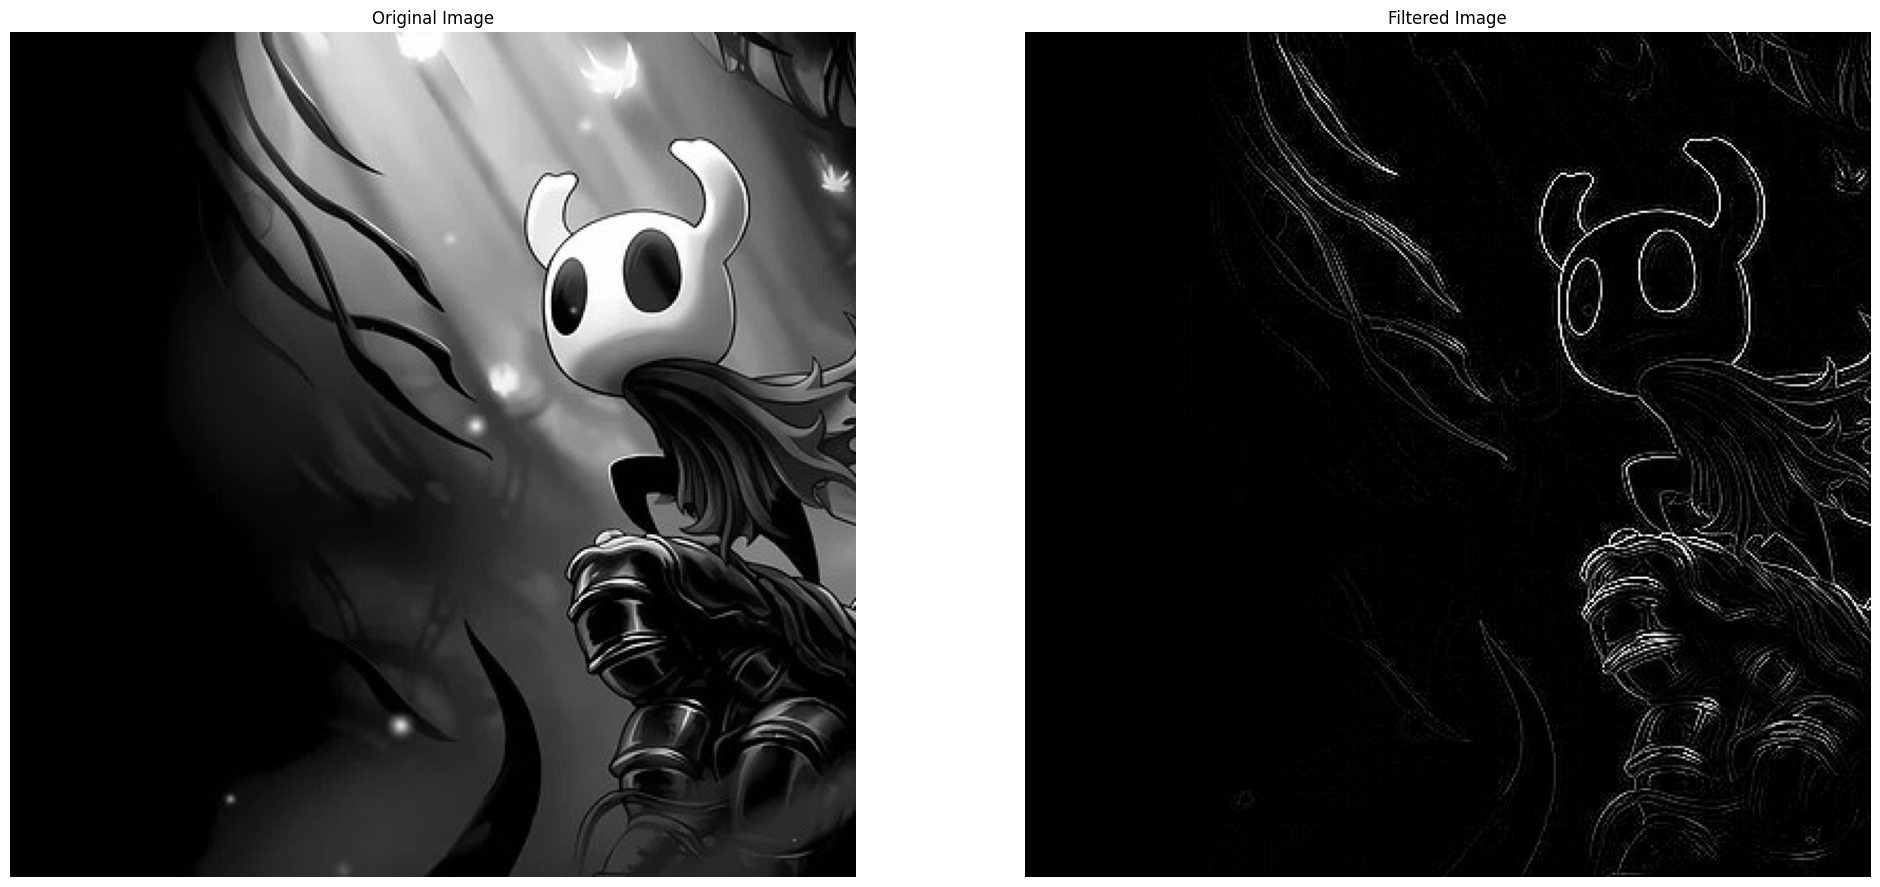

In [39]:
img_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero.jpg"
out_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero_laplacian.jpg"
laplacian_kernel = np.array([[0,1,0],
                            [1,-4,1],
                             [0,1,0]])
times = 10

# Calculamos tiempos en GPU con cudaEvents
start_event = Event()
end_event = Event()

start_event.record()
for _ in range(times):
  img_filteded = apply_kernel(img_path, laplacian_kernel)
end_event.synchronize() # Wait for the GPU to finish
end_event.record()


cuda_time_ms = cupy.cuda.get_elapsed_time(start_event,end_event)
t_paralelo = cuda_time_ms / times / 1000
print(f"Tiempo de ejecución promedio (CUDA Events): {t_paralelo} segundos")

# Calculamos tiempos en CPU
start = time.time()
for _ in range(times):
  img_filteded = apply_kernel_cpu(img_path, laplacian_kernel)
end = time.time()
t_secuencial = (end - start)/times
print(f"Tiempo de ejecución promedio (CPU): {t_secuencial} segundos")

# Speedup
speedup = t_secuencial / t_paralelo
print(f"Speedup: {speedup:.3f}x")

compare_images(img_path, img_filteded, out_path)

### Filtro promedio

Tiempo de ejecución promedio (CUDA Events): 0.007387350463867188 segundos
Tiempo de ejecución promedio (CPU): 1.451799702644348 segundos
Speedup: 196.525x


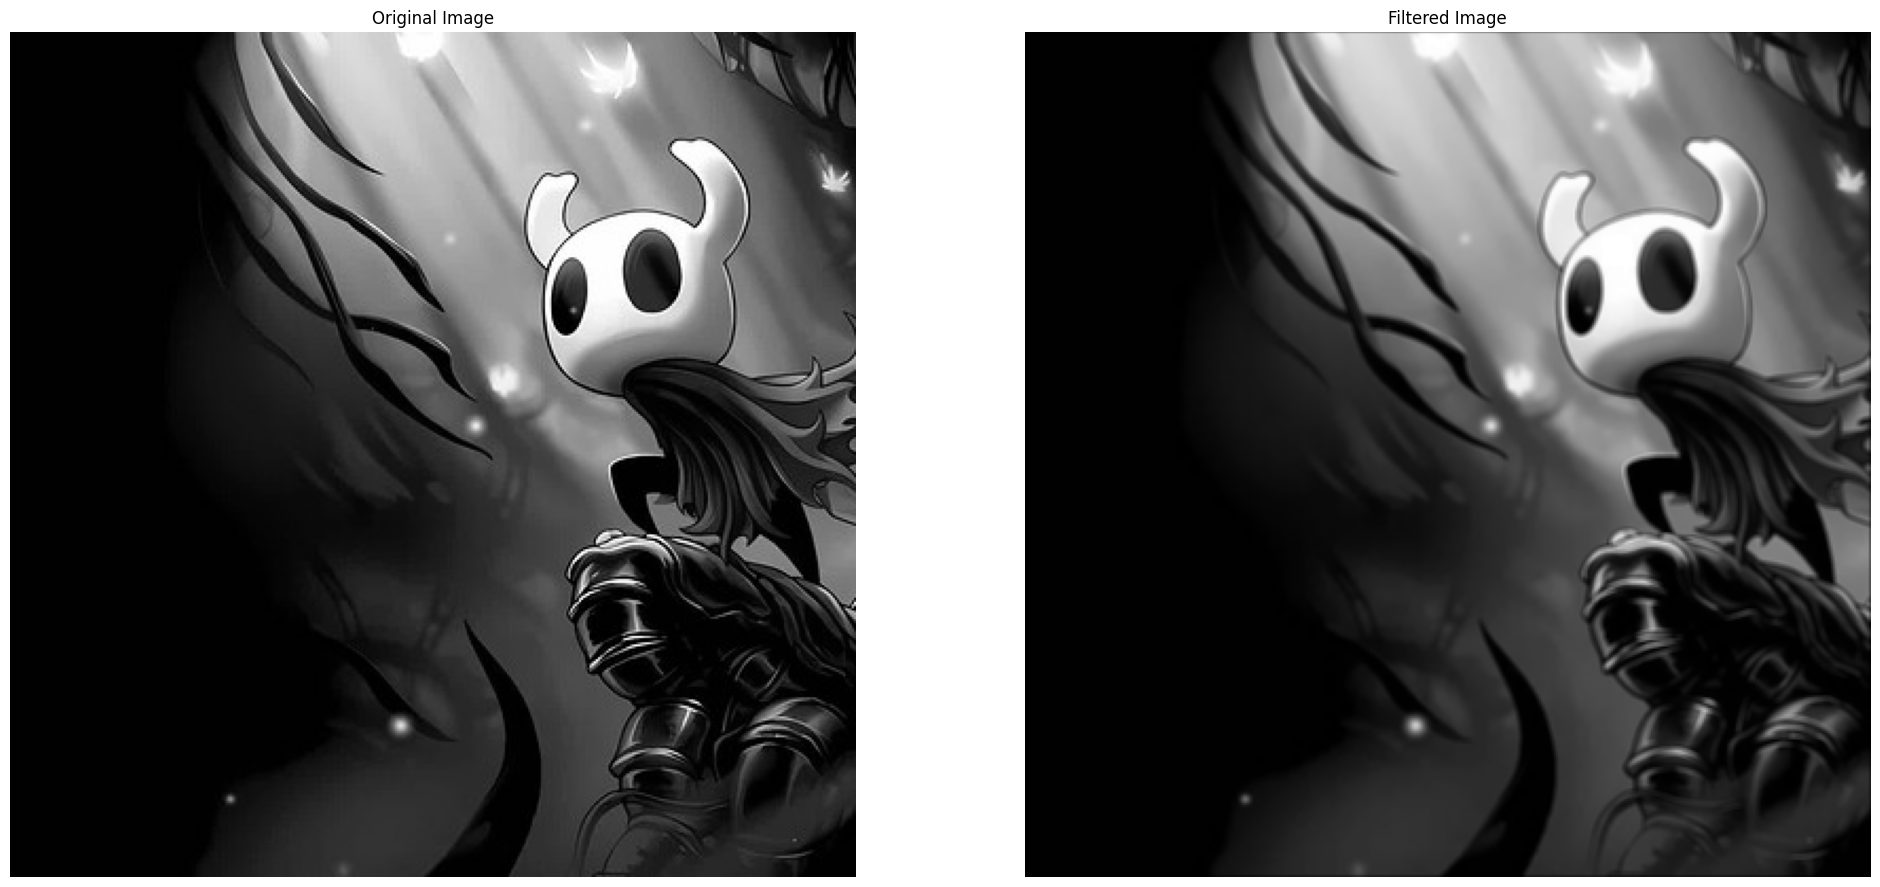

In [40]:
img_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero.jpg"
out_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero_promedio.jpg"
mean_kernel = np.array([[1/9,1/9,1/9],
                            [1/9,1/9,1/9],
                             [1/9,1/9,1/9]])
times = 10

# Calculamos tiempos en GPU con cudaEvents
start_event = Event()
end_event = Event()

start_event.record()
for _ in range(times):
  img_filteded = apply_kernel(img_path, mean_kernel)
end_event.synchronize() # Wait for the GPU to finish
end_event.record()


cuda_time_ms = cupy.cuda.get_elapsed_time(start_event,end_event)
t_paralelo = cuda_time_ms / times / 1000
print(f"Tiempo de ejecución promedio (CUDA Events): {t_paralelo} segundos")


# Calculamos tiempos en CPU
start = time.time()
for _ in range(times):
  img_filteded = apply_kernel_cpu(img_path, mean_kernel)
end = time.time()
t_secuencial = (end - start)/times
print(f"Tiempo de ejecución promedio (CPU): {t_secuencial} segundos")

# Speedup
speedup = t_secuencial / t_paralelo
print(f"Speedup: {speedup:.3f}x")

compare_images(img_path, img_filteded, out_path)

### Filtro Magnitud

Tiempo de ejecución promedio (CUDA Events): 0.006346883010864258 segundos
Tiempo de ejecución promedio (CPU): 0.18341121673583985 segundos
Speedup: 28.898x


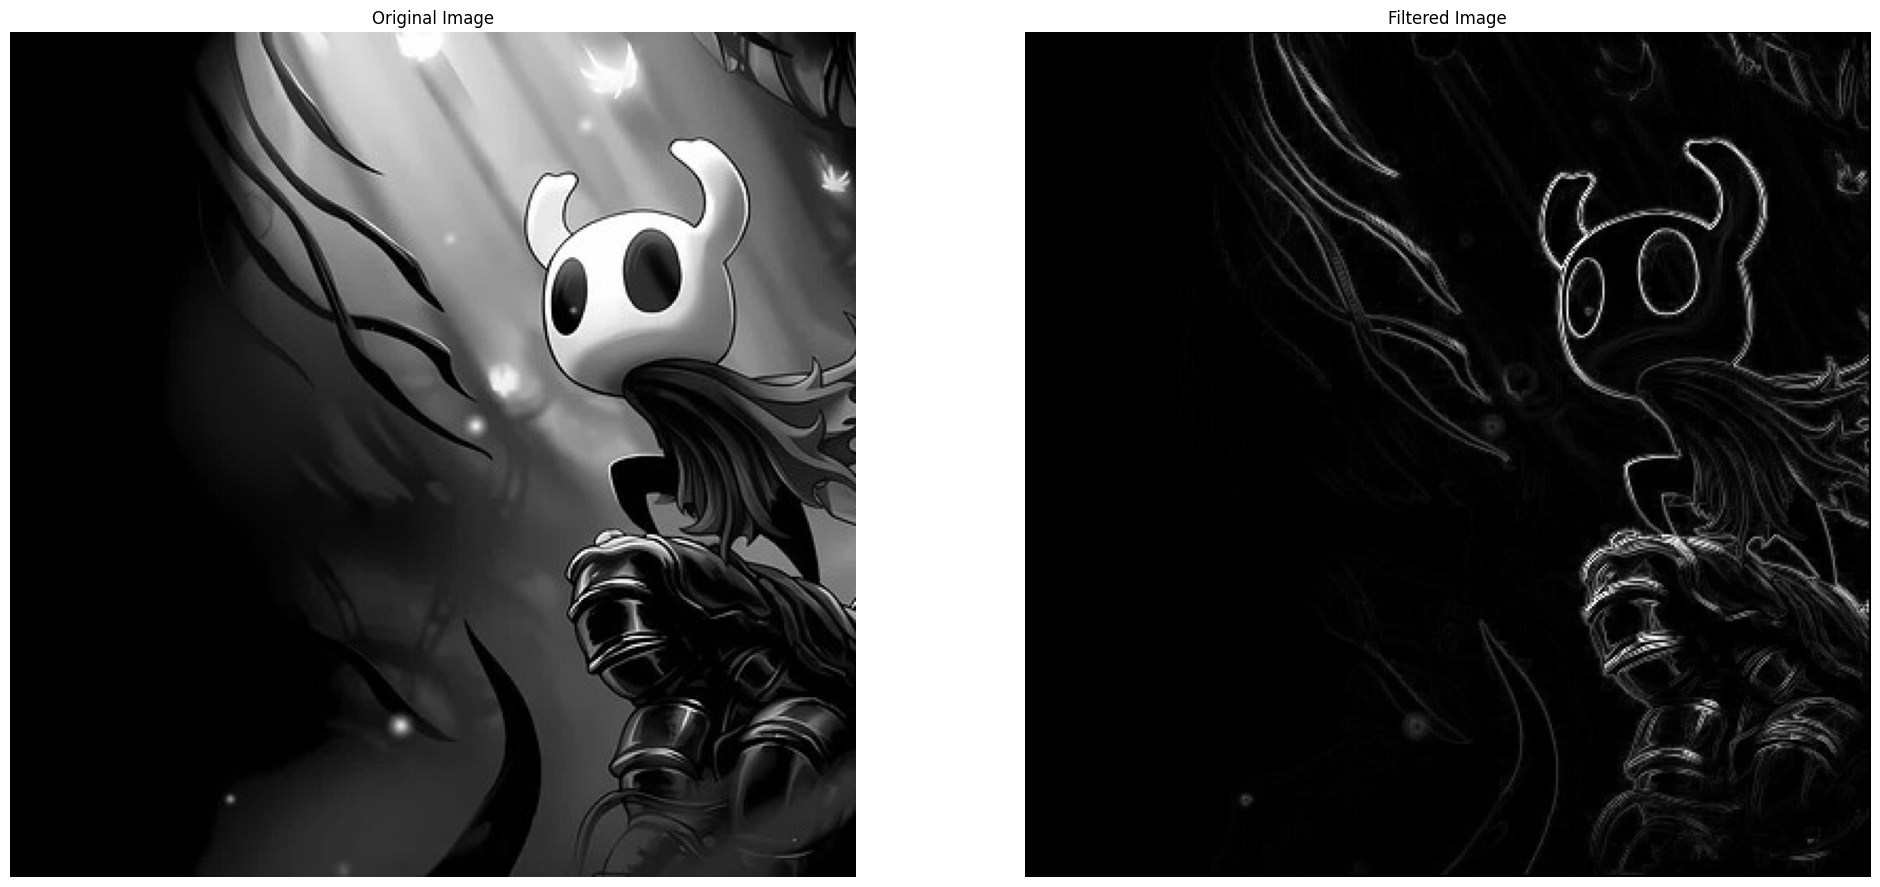

In [41]:
img_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero.jpg"
out_path = "/content/drive/MyDrive/Tareas Imagenes/Tarea1/caballero_magnitud.jpg"
times = 10

# Calculamos tiempos en GPU con cudaEvents
start_event = Event()
end_event = Event()

start_event.record()
for _ in range(times):
  img_filteded = apply_magnitud(img_path)
end_event.synchronize() # Wait for the GPU to finish
end_event.record()


cuda_time_ms = cupy.cuda.get_elapsed_time(start_event,end_event)
t_paralelo = cuda_time_ms / times / 1000
print(f"Tiempo de ejecución promedio (CUDA Events): {t_paralelo} segundos")


# Calculamos tiempos en CPU
start = time.time()
for _ in range(times):
  img_filteded = apply_magnitud_cpu(img_path)
end = time.time()
t_secuencial = (end - start)/times
print(f"Tiempo de ejecución promedio (CPU): {t_secuencial} segundos")

# Speedup
speedup = t_secuencial / t_paralelo
print(f"Speedup: {speedup:.3f}x")

compare_images(img_path, img_filteded, out_path)